# Solving Ordinary Differential Equation using Neural Networks

Neural networks train based on backpropogated errors signals from the training data. But what if there were some additional constraint on the results of the network that could help the training. When we consider **physical** constraints on the system in order to facilitate learning in the neural network we obtain what is called **physics informed neural networks (PINN) **. 

The particular use case we will consider for PINN's is solving ordinary differential equations. This post is inspired by the the work of [Hubert Baty, Leo Baty](https://arxiv.org/abs/2302.12260).

First Equation to Solve:

$$
\frac{dy}{dt} + 0.1y - \sin (\pi * t/2) = 0 
$$

Solving a differential equation means finding $y(t)$ such that this equation is satisfied. But, solving differential equations is hard and is mostly impossible. So, we often turn to numerical schemes in order to approximate the solution.

## Exact Solution using numerical integration

We will use the Runge-Kutta 4 (RK4) as our numerical integrator to plot the trajectory of the solution in \(t \in [0, 30]\). The RK4 method uses the expressed stated as a function of the first derivative, that is:

\[
\frac{dy}{dt} = \sin (\pi * t/2) - 0.1y
\]

With the initial condition: \(y(0) = 1\).

Using this, the method then estimates the change in the value of y for a given step size. Let us see this in action:


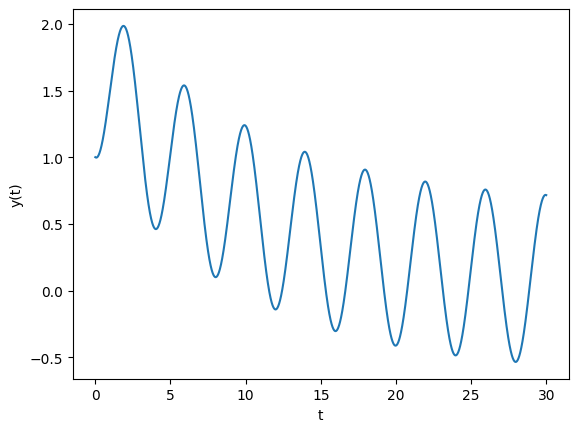

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def rk4(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_ode(f, t0, y0, t_end, h):
    t_values = np.arange(t0, t_end + h, h)
    y_values = np.zeros((len(t_values),) + np.shape(y0))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4(f, t_values[i - 1], y_values[i - 1], h)

    return t_values, y_values

def dy_dt(t, y):
    return np.sin(np.pi * t / 2 ) - 1/10 * y

t_values, y_values = solve_ode(dy_dt, 0, 1, 30, 0.01)

plt.xlabel("t")
plt.ylabel("y(t)")
plt.plot(t_values, y_values)
plt.show()

This is the exact solution to the differential equation. Well not exact since we have used a numerical integrator, but with a simple, non-chaotic system here integrated over a small time scale we can be pretty confident. 

But is to note is that the only way we can find the solution using this method is to step through the integrator. There is no machine where we can plug in a time and it will spit out the y - like what a function does - we can only tell where the particle will be at time t by starting at time 0 and walking through. 

## Use a neural network with no "physical" information

We can use neural networks as a universal approximator in order to try and learn the solution for $y(t)$. We can do this by taking a sample of the solution data set that we obtained using numerical integration, and iteratively learning based on these samples. Let us first create a basic neural network using PyTorch as well as a result plotting function.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class NN(nn.Module):
    def __init__(self, n_input=1, n_output=1, hidden_dim=32):

        super().__init__()

        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(n_input, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x
    
def plot_result(x, y, x_data, y_data, yh, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(
        x,
        y,
        color="blue",
        linewidth=2,
        alpha=0.8,
        linestyle="--",
        label="Exact solution",
    )
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label="Training data")
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=30,
            color="tab:green",
            alpha=0.4,
            label="Collocation points",
        )
    leg = plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.setp(leg.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    plt.text(2.965, 1.95, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.ylabel("y", fontsize="xx-large")
    plt.xlabel("t", fontsize="xx-large")
    plt.axis("on")

We can now sample our training set.

In [27]:
t_values = torch.Tensor(t_values)
y_values = torch.Tensor(y_values)

t_train = t_values[::100]
y_train = y_values[::100]

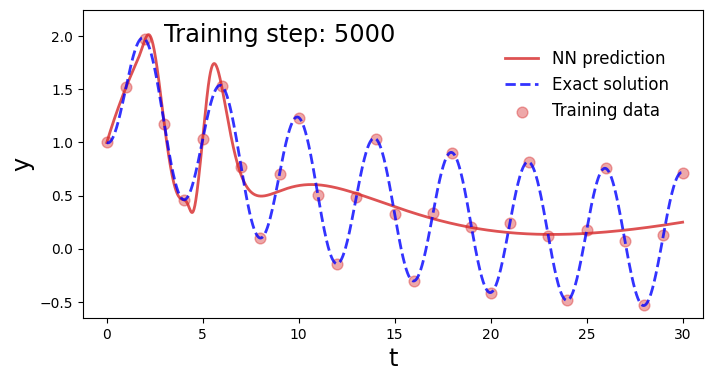

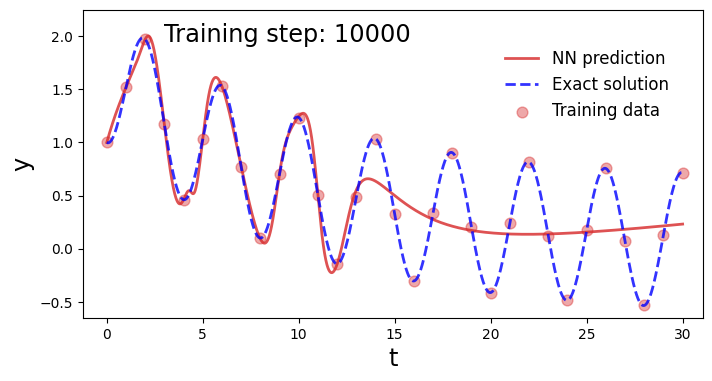

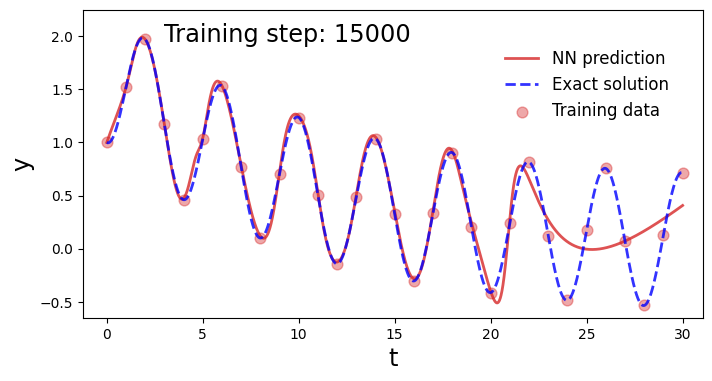

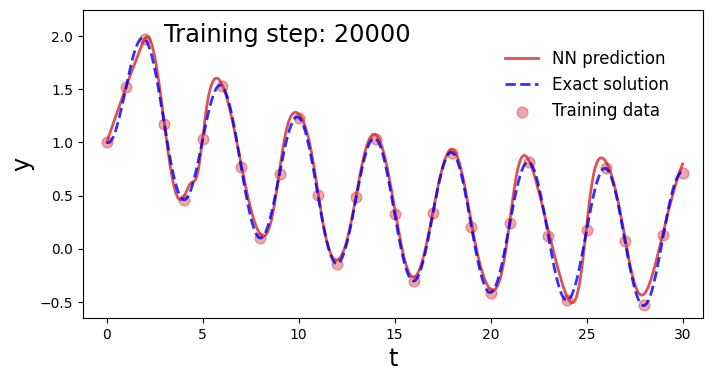

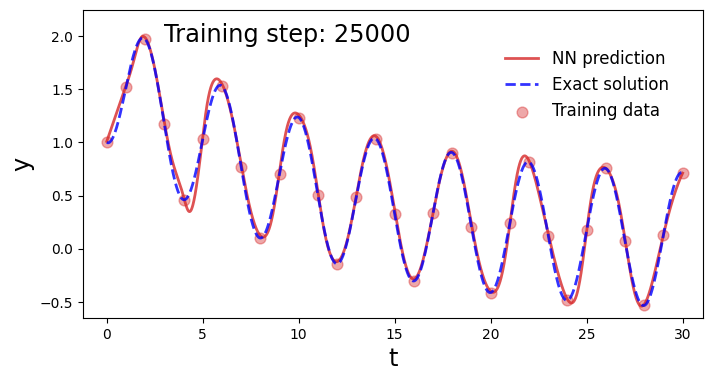

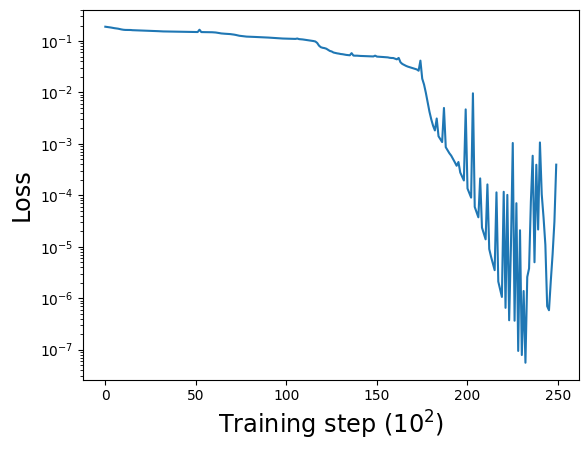

In [28]:
torch.manual_seed(123)
model = NN()
optimiser = optim.Adam(model.parameters(), lr=3e-3)

files = []
loss11_history = []

for i in range(25000):
    yh = model(t_train.unsqueeze(1)).squeeze()
    loss = torch.mean((yh - y_train) ** 2)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (i + 1) % 100 == 0:
        loss11_history.append(loss.detach())

        if (i + 1) % 5000 == 0:
            yh = model(t_values.unsqueeze(1)).detach()

            plot_result(t_values, y_values, t_train, y_train, yh)
            plt.show()
        else:
            plt.close("all")

fig11 = plt.figure(11)
plt.plot(loss11_history)
plt.xlabel("Training step ($10^2$)", fontsize="xx-large")
plt.ylabel("Loss", fontsize="xx-large")
plt.yscale("log")
plt.show()


## Using a physical loss on the neural network

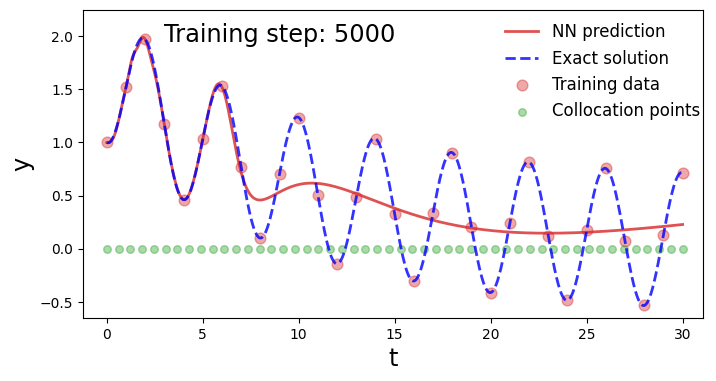

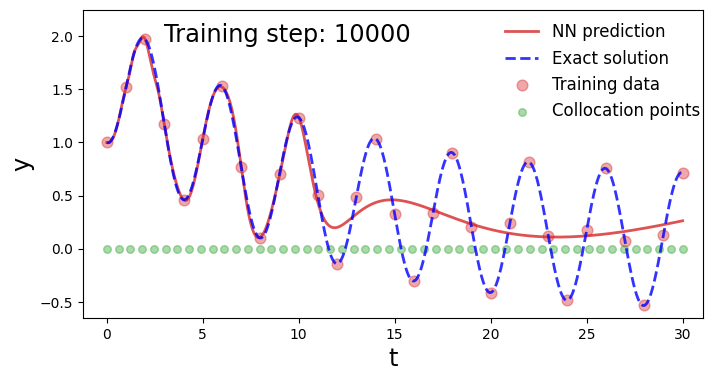

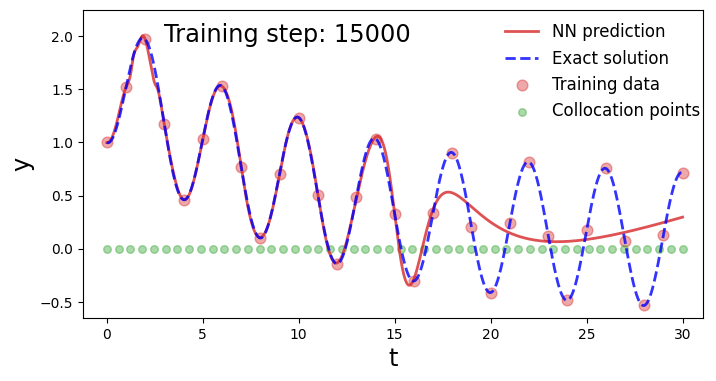

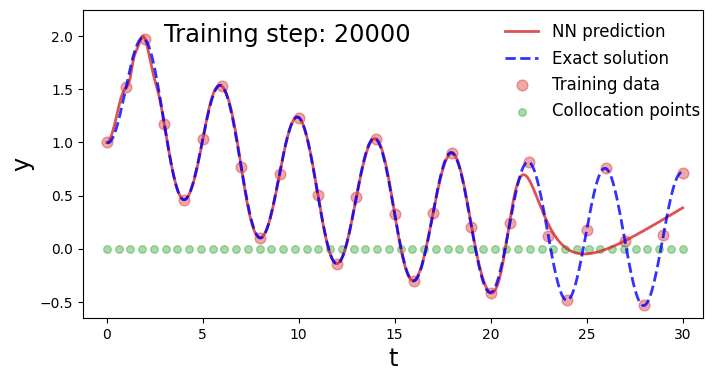

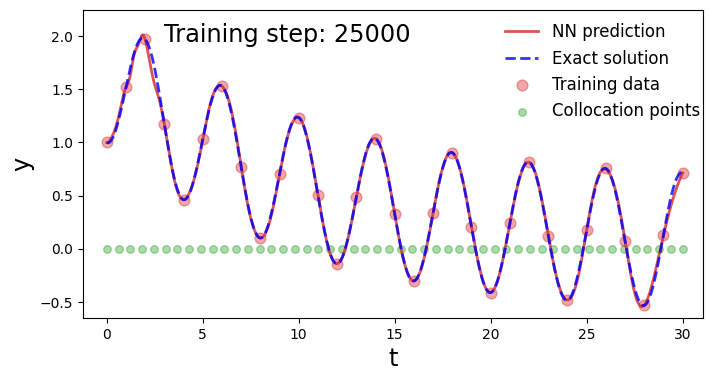

In [29]:
t_physics = torch.linspace(0, 30, 50).unsqueeze(1).requires_grad_(True)
lam = 0.1

torch.manual_seed(123)
model = NN()
optimiser = torch.optim.Adam(model.parameters(), lr=3e-3)

loss_history = []
loss2_history = []

for i in range(25000):

    optimiser.zero_grad()

    yh = model(t_train.unsqueeze(1)).squeeze()
    loss1 = 1.*torch.mean((yh-y_train)**2)

    yhp = model(t_physics.unsqueeze(1)).squeeze()
    dx = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]

    physics = dx + lam * yhp - torch.sin(np.pi * t_physics / 2)
    loss2 = (6e-2) * (torch.mean(physics**2))

    loss = loss1 + loss2
    loss.backward()
    optimiser.step()
    
    
    # We plot the result as training progresses ....................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())

                
        if (i+1) % 5000 == 0: 
            yh = model(t_values.unsqueeze(1)).detach().squeeze()
            xp = t_physics.detach()        
            plot_result(t_values, y_values, t_train, y_train, yh, xp)
            plt.show()
        else: 
            plt.close("all")
            
